In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import h5py
import os, sys 
import pandas as pd 

from paramiko import SSHClient
from scp import SCPClient

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [3]:
# set up local results directory
EXPT_DIRNAME = "cnn_att_encode_chipseq"
POOL_SIZE=20
EXPT_DIRNAME = os.path.join(EXPT_DIRNAME, "max_pool_%d"%POOL_SIZE)
RESULTSDIR = os.path.join(os.getcwd(), '..', 'results', EXPT_DIRNAME)  ## local path
if not os.path.exists(RESULTSDIR):
    os.makedirs(RESULTSDIR)

# set up remote paths and ssh clients 
username, hostname = os.getenv('BAMDEV1').split("@")
ssh = SSHClient()
ssh.load_system_host_keys()
ssh.connect(hostname=hostname, username=username)
remotehome = ssh.exec_command("echo $HOME")[1].readlines()[0].strip()
scp = SCPClient(ssh.get_transport())
REMOTEDIR = os.path.join(remotehome, "projects/higher_order_convolutions_full/results", EXPT_DIRNAME)

In [4]:
# get all remote directories 
tfids = [l.strip() for l in ssh.exec_command("ls %s"%REMOTEDIR)[1].readlines()]
_remove = []
for tfid in tfids:
    if len(ssh.exec_command("find %s -name \"test_metrics.csv\""%os.path.join(REMOTEDIR, tfid))[1].readlines()) < 13:
        _remove.append(tfid)
tfids = [tfid for tfid in tfids if tfid not in _remove]
print(len(tfids))

108


In [5]:
download = False
if download:
    for tfid in tfids:
        print("Downloading results for TF : %s"%tfid)
        remote_tfid_dir = os.path.join(REMOTEDIR, tfid)
        local_tfid_dir = os.path.join(RESULTSDIR, tfid)
        conv_type_dirs = [l.strip() for l in ssh.exec_command("ls %s"%remote_tfid_dir)[1].readlines()]

        for conv_type in conv_type_dirs:
            conv_type_dir = os.path.join(remote_tfid_dir, conv_type)
            res = [l.strip() for l in ssh.exec_command("ls %s"%conv_type_dir)[1].readlines()]

            # check for standard conv
            if "test_metrics.csv" in res:
                remote_path = os.path.join(conv_type_dir, "test_metrics.csv")
                local_path = os.path.join(local_tfid_dir, conv_type)
                if not os.path.exists(local_path):
                    os.makedirs(local_path)
                if not os.path.exists(os.path.join(local_path, "test_metrics.csv")):
                    scp.get(remote_path=remote_path, local_path=local_path)

                remote_path = os.path.join(conv_type_dir, "history.csv")
                local_path = os.path.join(local_tfid_dir, conv_type)
                if not os.path.exists(os.path.join(local_path, "history.csv")):
                    scp.get(remote_path=remote_path, local_path=local_path)

            else:
                for l1_dir in res:
                    remote_path = os.path.join(conv_type_dir, l1_dir, "test_metrics.csv")
                    local_path = os.path.join(local_tfid_dir, conv_type, l1_dir)
                    if not os.path.exists(local_path):
                        os.makedirs(local_path)
                    if not os.path.exists(os.path.join(local_path, "test_metrics.csv")):
                        scp.get(remote_path=remote_path, local_path=local_path)

                    remote_path = os.path.join(conv_type_dir, l1_dir, "history.csv")
                    local_path = os.path.join(local_tfid_dir, conv_type, l1_dir)
                    if not os.path.exists(os.path.join(local_path, "history.csv")):
                        scp.get(remote_path=remote_path, local_path=local_path)

### Collect results from local 

In [6]:
reg_test_metrics_df = {'TFID':[],  'loss':[], 'ACC':[], 'AUROC':[], 'AUPR':[]}
pairwise_test_metrics_df = {'TFID':[], "l1":[], 'loss':[], 'ACC':[], 'AUROC':[], 'AUPR':[]}
nn_test_metrics_df = {'TFID':[], "l1":[], 'loss':[], 'ACC':[], 'AUROC':[], 'AUPR':[]}

for tfid in tfids:
    #print("Collecting results for TF : %s ..."%tfid)
    tfid_dir = os.path.join(RESULTSDIR, tfid)
    
    # get regular conv results 
    reg_test_metrics_df['TFID'].append(tfid)
    reg_dir = os.path.join(tfid_dir, "regular_conv_results")
    reg_path = os.path.join(reg_dir, "test_metrics.csv")
    df=pd.read_csv(reg_path, index_col=[0])
    names = df.Metric.values
    values = df.Value.values
    for name, value in zip(names, values):
        reg_test_metrics_df[name].append(value)
    # get pairwise conv results 
    pairwise_dir = os.path.join(tfid_dir, "pairwise_conv_results")
    for i, l1folder in enumerate(os.listdir(pairwise_dir)):
        pairwise_test_metrics_df['TFID'].append(tfid)
        pairwise_test_metrics_df['l1'].append(str(l1folder).split("=")[-1])
        fname = os.path.join(pairwise_dir, l1folder, "test_metrics.csv")
        df=pd.read_csv(fname, index_col=[0])
        names = df.Metric.values
        values = df.Value.values
        for name, value in zip(names, values):
            pairwise_test_metrics_df[name].append(value)
    
    # get nearest neighbor conv results 
    nn_dir = os.path.join(tfid_dir, "nearest_neighbor_conv_results")
    for i, l1folder in enumerate(os.listdir(nn_dir)):
        nn_test_metrics_df['TFID'].append(tfid)
        nn_test_metrics_df['l1'].append(str(l1folder).split("=")[-1])
        fname = os.path.join(nn_dir, l1folder, "test_metrics.csv")
        df=pd.read_csv(fname, index_col=[0])
        names = df.Metric.values
        values = df.Value.values
        for name, value in zip(names, values):
            nn_test_metrics_df[name].append(value)
    
    
    # get nearest neighbor conv results 
    tfid_nn_dir = os.path.join(tfid_dir, "nearest_neighbor_conv_results")

reg_test_metrics_df = pd.DataFrame(reg_test_metrics_df).sort_values(by='TFID')
pairwise_test_metrics_df = pd.DataFrame(pairwise_test_metrics_df).sort_values(by='TFID')
nn_test_metrics_df = pd.DataFrame(nn_test_metrics_df).sort_values(by='TFID')
highorder_conv_test_metrics = {'pairwise':pairwise_test_metrics_df, 'nearest neighbor':nn_test_metrics_df}
metric_names = list(reg_test_metrics_df.columns[-3:])

In [17]:
#reg_test_metrics_df[reg_test_metrics_df['TFID'] == 'JUND_K562_JunD_Stanford']
reg_test_metrics_df.TFID.values

array(['ARID3A_K562_ARID3A_-sc-8821-_Stanford',
       'ATF1_K562_ATF1_-06-325-_Harvard', 'ATF3_K562_ATF3_HudsonAlpha',
       'BACH1_K562_Bach1_-sc-14700-_Stanford',
       'BCL3_K562_BCL3_HudsonAlpha',
       'BCLAF1_K562_BCLAF1_-SC-101388-_HudsonAlpha',
       'BDP1_K562_BDP1_Harvard',
       'BHLHE40_K562_BHLHE40_-NB100-1800-_Stanford',
       'CBX3_K562_CBX3_-SC-101004-_HudsonAlpha',
       'CCNT2_K562_CCNT2_Harvard',
       'CEBPB_K562_CEBPB_-SC-150-_HudsonAlpha',
       'CEBPB_K562_CEBPB_Stanford', 'CHD1_K562_CHD1_-A301-218A-_Broad',
       'CHD2_K562_CHD2_-AB68301-_Stanford',
       'CTCFL_K562_CTCFL_-SC-98982-_HudsonAlpha',
       'CTCF_K562_CTCF_-SC-15914-_Stanford',
       'CTCF_K562_CTCF_-SC-5916-_HudsonAlpha', 'CTCF_K562_CTCF_Broad',
       'CTCF_K562_CTCF_UT-A', 'CTCF_K562_CTCF_UW', 'E2F4_K562_E2F4_USC',
       'E2F6_K562_E2F6_HudsonAlpha', 'E2F6_K562_E2F6_USC',
       'EGR1_K562_Egr-1_HudsonAlpha',
       'ELF1_K562_ELF1_-SC-631-_HudsonAlpha', 'EP300_K562_p300_Stanford',

### plots for NN conv

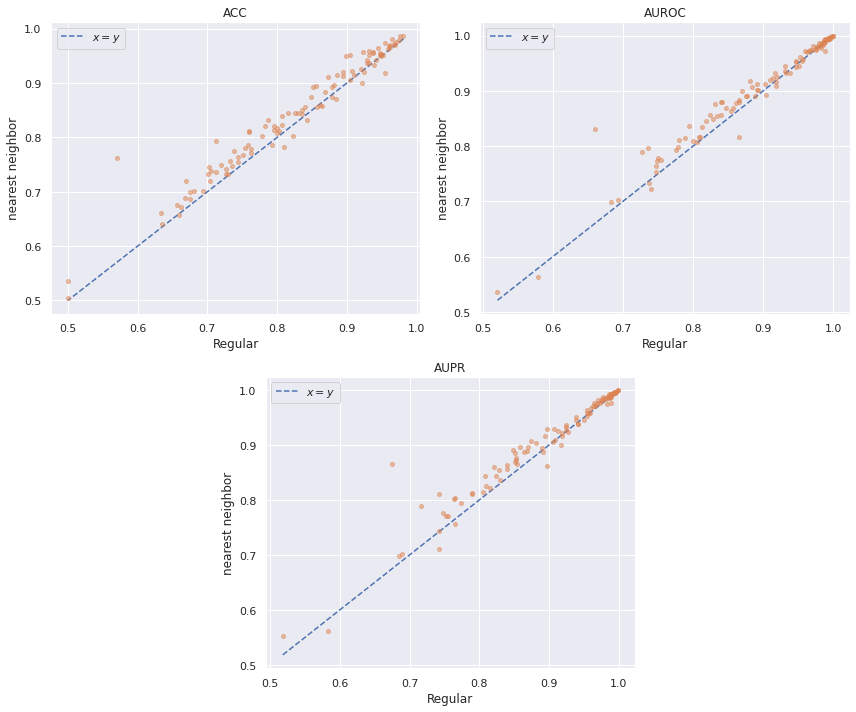

In [58]:
model_type = 'nearest neighbor'
test_metrics_df = highorder_conv_test_metrics[model_type]
#test_metrics_df
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 8)
for j,metric_name in enumerate(metric_names):
    #plt.subplot(3, 1, j+1)
    best_l1_factor_idx = test_metrics_df.groupby('TFID')[metric_name].idxmax().values
    best_l1_factor = test_metrics_df[['TFID','l1']].iloc[best_l1_factor_idx]
    best_metric = test_metrics_df.groupby('TFID').aggregate({metric_name:'max'})
    best_metric['TFID'] = best_metric.index   
    best_metric.index = np.arange(len(tfids))
    best_metric = best_metric.iloc[:, ::-1]
    best_metric = pd.merge(best_metric, best_l1_factor, on="TFID")
    reg_metric = reg_test_metrics_df[['TFID',metric_name]]
    assert np.all(best_metric.TFID.values==reg_metric.TFID.values) ## make sure comparing the right TF results
    
    if j == 0:
        ax = fig.add_subplot(gs[0, :4])
    if j == 1:
        ax = fig.add_subplot(gs[0, 4:])
    if j == 2:
        ax = fig.add_subplot(gs[1, 4-2:4+2])
    
    reg = reg_metric[metric_name].values
    a,b = reg.max(), reg.min()
    x = np.linspace(a, b, 100)
    ax.plot(x,x,'--', label='$x=y$')
    ax.plot(reg, best_metric[metric_name].values, "o", markersize=4, alpha=0.5)
    ax.set_xlabel("Regular")
    ax.set_ylabel(model_type)
    ax.legend(loc='best')
    ax.set_title(metric_name)
fig.tight_layout()

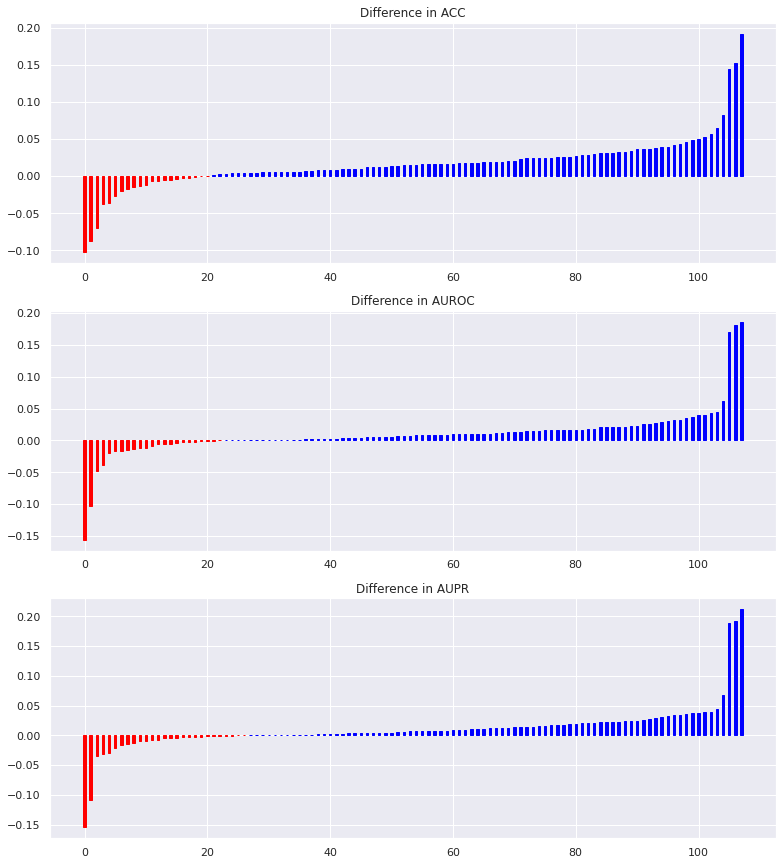

In [38]:
model_type = 'nearest neighbor'
test_metrics_df = highorder_conv_test_metrics[model_type]
#test_metrics_df
plt.figure(figsize=(13, 15))
for j,metric_name in enumerate(metric_names):
    plt.subplot(3, 1, j+1)
    best_l1_factor_idx = test_metrics_df.groupby('TFID')[metric_name].idxmax().values
    best_l1_factor = test_metrics_df[['TFID','l1']].iloc[best_l1_factor_idx]
    best_metric = test_metrics_df.groupby('TFID').aggregate({metric_name:'max'})
    best_metric['TFID'] = best_metric.index   
    best_metric.index = np.arange(len(tfids))
    best_metric = best_metric.iloc[:, ::-1]
    best_metric = pd.merge(best_metric, best_l1_factor, on="TFID")
    reg_metric = reg_test_metrics_df[['TFID',metric_name]]
    assert np.all(best_metric.TFID.values==reg_metric.TFID.values) ## make sure comparing the right TF results 
    diff=(best_metric[metric_name]-reg_metric[metric_name]).values
    idx = np.argsort(diff) ## ascending
    barlist = plt.bar(np.arange(len(diff)), 
            diff[idx], 
            width=0.4, edgecolor='none')
    plt.title("Difference in %s"%metric_name)
    for bar in barlist:
        if bar._height > 0:
            bar.set_color("blue")
        else:
            bar.set_color("red")

In [82]:
cond = (reg_test_metrics_df['AUROC'] > 0.85).values == (reg_test_metrics_df['AUROC'] < 0.91).values
idx=np.where(cond)[0]
reg_test_metrics_df.iloc[idx]

,TFID,loss,ACC,AUROC,AUPR
2,ATF3_K562_ATF3_HudsonAlpha,0.454699,0.807000,0.881718,0.907316
9,CCNT2_K562_CCNT2_Harvard,0.437907,0.800000,0.891538,0.905459
20,E2F4_K562_E2F4_USC,0.475127,0.792000,0.865462,0.868235
38,HDAC2_K562_HDAC2_-SC-6296-_HudsonAlpha,0.449957,0.802000,0.875472,0.869511
53,MXI1_K562_Mxi1_-AF4185-_Stanford,0.481370,0.783000,0.893378,0.909021
62,PML_K562_PML_-SC-71910-_HudsonAlpha,0.388883,0.835000,0.903212,0.913531
63,POLR2A_K562_Pol2-4H8_HudsonAlpha,0.434463,0.795000,0.877338,0.889730
65,POLR2A_K562_Pol2_HudsonAlpha,0.502916,0.763000,0.853792,0.852858
72,RCOR1_K562_COREST_-ab24166-_Stanford,0.479481,0.778000,0.861122,0.864789
82,SP1_K562_SP1_HudsonAlpha,0.386934,0.822000,0.904560,0.917033


### plots for pairwise conv

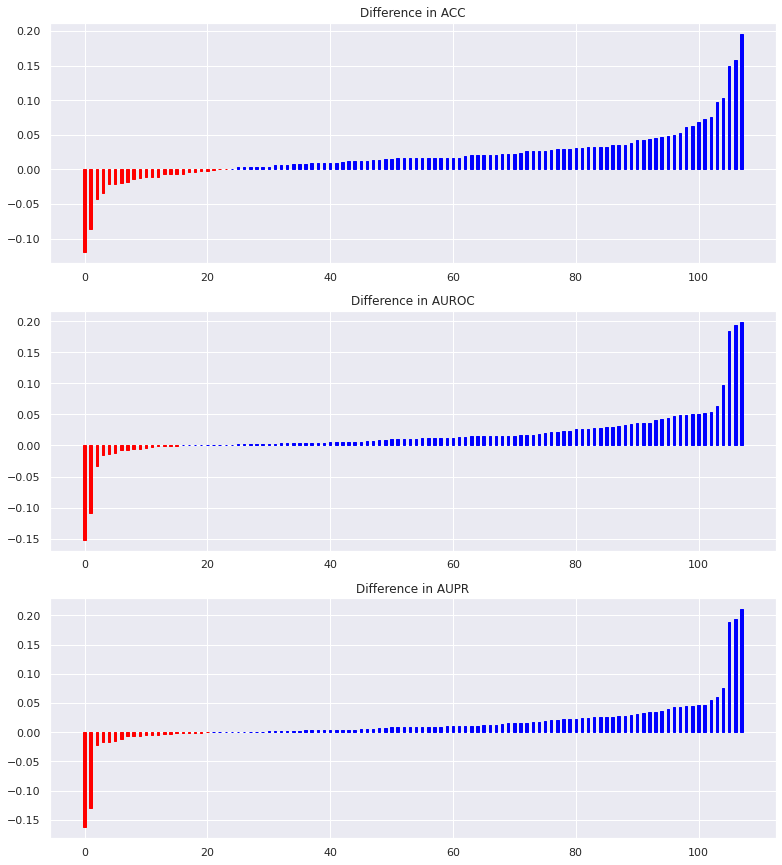

In [11]:
model_type = 'pairwise'
test_metrics_df = highorder_conv_test_metrics[model_type]

plt.figure(figsize=(13, 15))
for j,metric_name in enumerate(metric_names):
    plt.subplot(3, 1, j+1)
    best_l1_factor_idx = test_metrics_df.groupby('TFID')[metric_name].idxmax().values
    best_l1_factor = test_metrics_df[['TFID','l1']].iloc[best_l1_factor_idx]
    best_metric = test_metrics_df.groupby('TFID').aggregate({metric_name:'max'})
    best_metric['TFID'] = best_metric.index
    best_metric.index = np.arange(len(tfids))
    best_metric = best_metric.iloc[:, ::-1]
    
    best_metric = pd.merge(best_metric, best_l1_factor, on="TFID")
    reg_metric = reg_test_metrics_df[['TFID',metric_name]]
    assert np.all(best_metric.TFID.values==reg_metric.TFID.values) ## make sure comparing the right TF results 
    diff=(best_metric[metric_name]-reg_metric[metric_name]).values
    idx = np.argsort(diff)

    barlist = plt.bar(np.arange(len(diff)), 
            diff[idx], 
            width=0.4, edgecolor='none')
    plt.title("Difference in %s"%metric_name)
    for bar in barlist:
        if bar._height > 0:
            bar.set_color("blue")
        else:
            bar.set_color("red")

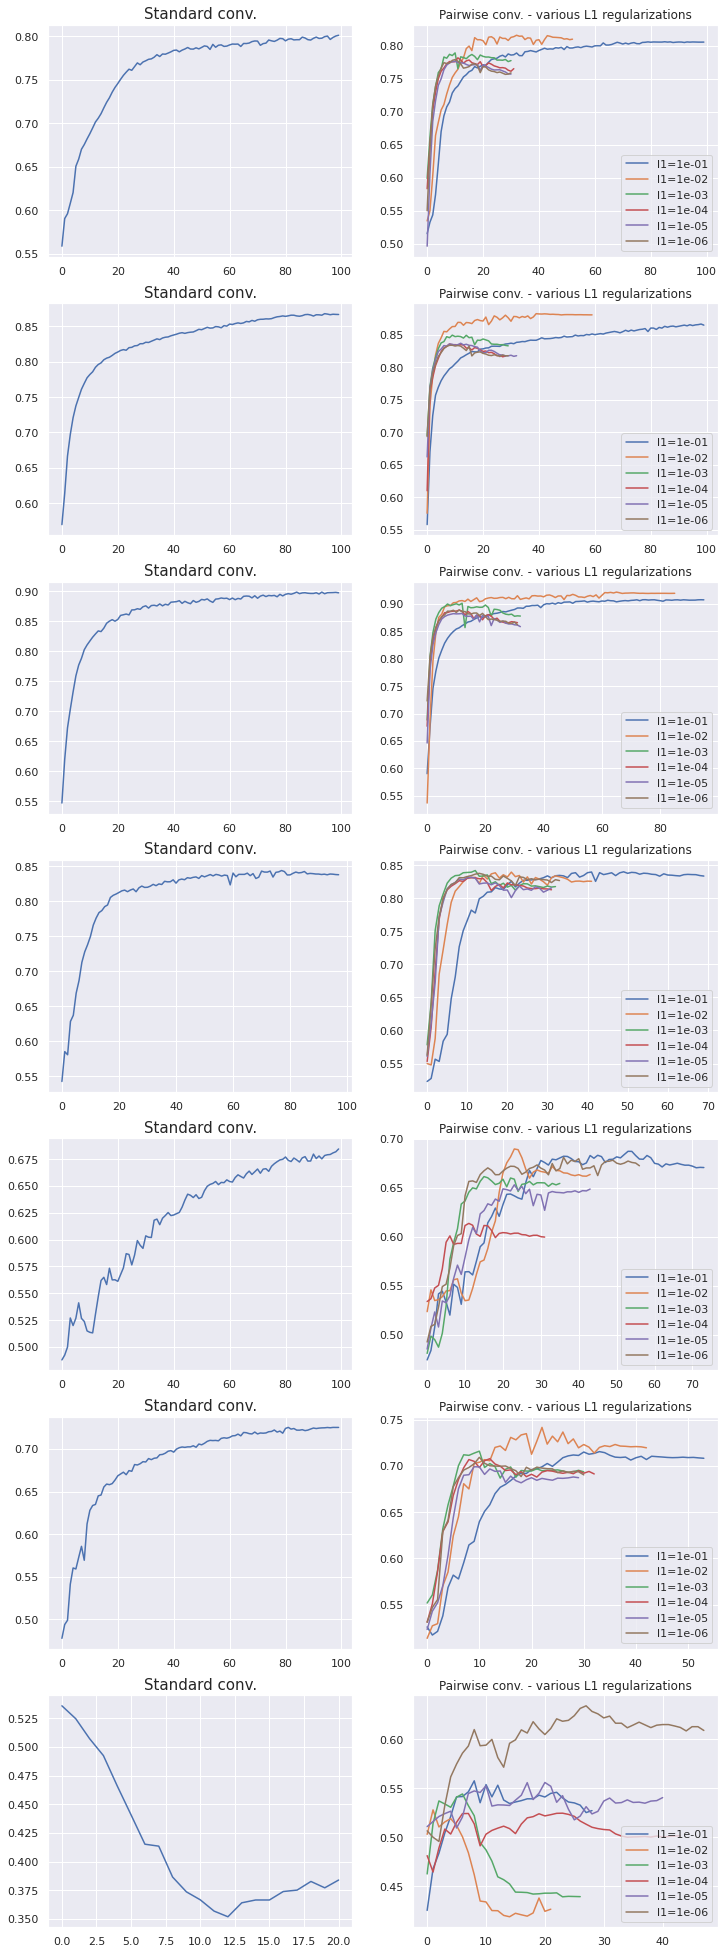

In [12]:
fig, Ax = plt.subplots(7, 2, figsize=(12, 35))
for i, tfid in enumerate(tfids):
    ax = Ax[i]
    
    regular_resultdir = os.path.join(RESULTSDIR, tfid, 'regular_conv_results')
    history_file_path = os.path.join(regular_resultdir, 'history.csv')
    history = pd.read_csv(history_file_path)
    ax[0].plot(history['val_AUROC'])
    #ax[0].plot(history['AUROC'])
    #ax[0].set_ylim(top=0.9)
    ax[0].set_title("Standard conv.", fontsize=15)
    
    pairwise_resultdir = os.path.join(RESULTSDIR, tfid, 'pairwise_conv_results')
    l1_factors = os.listdir(pairwise_resultdir)
    for l1_factor in l1_factors:
        history_file_path = os.path.join(pairwise_resultdir, l1_factor, 'history.csv')
        history = pd.read_csv(history_file_path)
        ax[1].plot(history['val_AUROC'], label=l1_factor)
        #ax[1].plot(history['AUROC'])
    #ax[1].set_ylim(top=0.9)
    ax[1].legend(loc='best')
    ax[1].set_title("Pairwise conv. - various L1 regularizations")
    
    if i == Ax.shape[0] - 1:
        break

In [13]:
pairwise_test_metrics_df

,TFID,l1,loss,ACC,AUROC,AUPR
0,ARID3A_K562_ARID3A_-sc-8821-_Stanford,1e-01,0.519775,0.786000,0.852178,0.858376
1,ARID3A_K562_ARID3A_-sc-8821-_Stanford,1e-02,0.814940,0.757000,0.868214,0.872478
2,ARID3A_K562_ARID3A_-sc-8821-_Stanford,1e-03,1.423028,0.748000,0.835996,0.834440
3,ARID3A_K562_ARID3A_-sc-8821-_Stanford,1e-04,1.010218,0.721000,0.798678,0.791673
4,ARID3A_K562_ARID3A_-sc-8821-_Stanford,1e-05,0.726374,0.736000,0.816886,0.820573
...,...,...,...,...,...,...
642,ZNF274_K562_ZNF274_USC,1e-01,190.316986,0.500000,0.637509,0.603799
643,ZNF274_K562_ZNF274_USC,1e-02,16.400162,0.842105,0.880908,0.918945
644,ZNF274_K562_ZNF274_USC,1e-03,2.606389,0.605263,0.883159,0.913366
645,ZNF274_K562_ZNF274_USC,1e-04,0.559090,0.851974,0.913695,0.942047
